In [2]:
#Download the dataset from opensig
import urllib.request
urllib.request.urlretrieve('http://opendata.deepsig.io/datasets/2016.10/RML2016.10a.tar.bz2', 'RML2016.10a.tar.bz2')

('RML2016.10a.tar.bz2', <http.client.HTTPMessage at 0x7fe3d1645be0>)

In [0]:
#decompress the .bz2 file into .tar file
import sys
import os
import bz2
zipfile = bz2.BZ2File('./RML2016.10a.tar.bz2') # open the file
data = zipfile.read() # get the decompressed data

In [4]:
#write the .tar file
open('./RML2016.10a.tar', 'wb').write(data) # write a uncompressed file

640952320

In [0]:
#extract the .tar file
import tarfile
my_tar = tarfile.open('./RML2016.10a.tar')
my_tar.extractall('./') # specify which folder to extract to
my_tar.close()

In [0]:
#extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open("RML2016.10a_dict.pkl",'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [7]:
# Import all the things we need ---
%matplotlib inline
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
# Partition the data
#  into training and test sets of the form we can train/test on 
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
print(X_train.shape)
print(X_test.shape)
print(X_test.shape)


(110000, 2, 128)
(110000, 2, 128)
(110000, 2, 128)


In [9]:
#one-hot encoding the label
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
# Print 11 different modulation techniques
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]                #(110000, 11)
y_test=lbl_encoded[test_idx]               #(110000, 11)


print(train_idx)
print(train_idx.shape)

print(y_train)
print(y_test[0].shape)

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']
[ 40917 196793  21915 ...  30900 138950 196208]
(110000,)
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]
(11,)


In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

print(in_shp+[1])

(110000, 2, 128) [2, 128]
[2, 128, 1]


In [11]:
################# Change IQ to amplitude and phase
X_cmplx = X_train[:,0,:] + 1j* X_train[:,1,:]    
X_amp = np.abs(X_cmplx)
X_ang = np.arctan2(X_train[:,1,:],X_train[:,0,:]) / np.pi
X_amp = np.reshape(X_amp,(-1,1,128))
X_ang = np.reshape(X_ang,(-1,1,128))


X_train_AmpPhs = np.concatenate((X_amp,X_ang), axis=1) 
print('X_train_AmpPhs')
print(X_train_AmpPhs.shape)
print(X_train_AmpPhs) 


############Change IQ to amplitude and phase for test data
X_cmplx = X_test[:,0,:] + 1j* X_test[:,1,:]    
X_amp = np.abs(X_cmplx)
X_ang = np.arctan2(X_test[:,1,:],X_test[:,0,:]) / np.pi 
X_amp = np.reshape(X_amp,(-1,1,128))
X_ang = np.reshape(X_ang,(-1,1,128))
X_test_AmpPhs = np.concatenate((X_amp,X_ang), axis=1) 

print('X_test_AmpPhs')
print(X_test_AmpPhs.shape)
print(X_test_AmpPhs) 


X_train_AmpPhs
(110000, 2, 128)
[[[ 0.0051044   0.0061489   0.00667689 ...  0.01700923  0.00820559
    0.00804504]
  [ 0.9415724  -0.05589808  0.63457465 ...  0.03925904 -0.98261064
   -0.48542148]]

 [[ 0.00648659  0.00783643  0.00885146 ...  0.00736231  0.00662258
    0.00629813]
  [ 0.5293936   0.6189099   0.64406085 ... -0.71740836 -0.63531923
   -0.5482424 ]]

 [[ 0.00786629  0.00683073  0.00742116 ...  0.00952061  0.00287621
    0.01872616]
  [-0.19420844  0.976841   -0.344762   ... -0.9445802   0.08971114
   -0.92454016]]

 ...

 [[ 0.00723926  0.00489992  0.01000861 ...  0.00838031  0.00930211
    0.00732421]
  [-0.3156976  -0.260527   -0.37100062 ... -0.31621248 -0.28211805
   -0.11709256]]

 [[ 0.00416415  0.00541707  0.00709697 ...  0.0070485   0.01021685
    0.01296608]
  [ 0.21116725  0.2135336   0.20826402 ...  0.18405817  0.19453733
    0.20456748]]

 [[ 0.00401433  0.00701364  0.00851337 ...  0.00825179  0.00787112
    0.00877088]
  [ 0.11700282  0.21001782  0.25230047 

In [12]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#X_train = X_train.reshape([X_train.shape[0],256])
X_train = X_train_AmpPhs.reshape([X_train.shape[0],256])
X_train = sc.fit_transform(X_train)
X_train = X_train.reshape([X_train.shape[0],2,128])
#X_test = X_test.reshape([1600,256])
#X_test18 = X_test18.reshape([X_test18.shape[0],256])
X_test = X_test_AmpPhs.reshape([X_test.shape[0],256])
X_test = sc.transform(X_test)
X_test = X_test.reshape([X_test.shape[0],2,128])

print('X_train')
print(X_train.shape)
print(X_train)
print('X_test')
print(X_test.shape)
print(X_test)

X_train
(110000, 2, 128)
[[[-7.71067202e-01 -4.68323916e-01 -3.23642462e-01 ...  2.50324869e+00
    9.32335258e-02  4.81031239e-02]
  [ 1.73611760e+00 -3.49546820e-02  1.18708277e+00 ...  1.35767683e-01
   -1.67375827e+00 -7.96414256e-01]]

 [[-3.74392539e-01  1.79576688e-02  3.02323788e-01 ... -1.35956511e-01
   -3.36796314e-01 -4.19582635e-01]
  [ 1.00744081e+00  1.15783083e+00  1.20384347e+00 ... -1.20274913e+00
   -1.05985260e+00 -9.07530427e-01]]

 [[ 2.15680562e-02 -2.71847337e-01 -1.09400734e-01 ...  4.54509199e-01
   -1.35450518e+00  2.90767312e+00]
  [-2.71790594e-01  1.79050708e+00 -5.43256044e-01 ... -1.60460782e+00
    2.21780643e-01 -1.57311738e+00]]

 ...

 [[-1.58383399e-01 -8.28230262e-01  6.35415852e-01 ...  1.42548025e-01
    3.91103685e-01 -1.44877166e-01]
  [-4.86567110e-01 -3.96655232e-01 -5.89615703e-01 ... -4.93048400e-01
   -4.35500324e-01 -1.44922450e-01]]

 [[-1.04090941e+00 -6.79207742e-01 -2.02720553e-01 ... -2.21811250e-01
    6.39594853e-01  1.36557436e+00

In [13]:
X_train = X_train.reshape([X_train.shape[0],256])
X_test = X_test.reshape([X_test.shape[0],256])
print('X_train')
print(X_train.shape)
print(X_train)
print('X_test')
print(X_test.shape)
print(X_test)

X_train
(110000, 256)
[[-0.7710672  -0.46832392 -0.32364246 ...  0.13576768 -1.6737583
  -0.79641426]
 [-0.37439254  0.01795767  0.3023238  ... -1.2027491  -1.0598526
  -0.9075304 ]
 [ 0.02156806 -0.27184734 -0.10940073 ... -1.6046078   0.22178064
  -1.5731174 ]
 ...
 [-0.1583834  -0.82823026  0.63541585 ... -0.4930484  -0.43550032
  -0.14492245]
 [-1.0409094  -0.67920774 -0.20272055 ...  0.39191204  0.40708145
   0.42402253]
 [-1.0839064  -0.21913807  0.20499977 ...  0.6392587   0.62146735
   0.612436  ]]
X_test
(110000, 256)
[[-1.2524039e-01 -1.4283879e+00  1.2047418e+00 ...  1.4156665e+00
  -4.7882092e-01 -1.5112780e-02]
 [-1.5737094e-01 -1.5981603e+00 -5.6714199e-02 ...  1.5487407e+00
  -1.3023404e+00 -1.5939763e+00]
 [-2.8497007e-01 -1.9159918e-01  6.1779143e-03 ...  9.9874711e-01
   1.5586555e+00  1.6367851e+00]
 ...
 [ 2.3332641e-02  1.8452546e-02  8.2580093e-03 ... -1.6968843e+00
  -1.7004895e+00  1.8190781e+00]
 [ 5.7761267e-02 -1.6480417e-03  2.8793821e-02 ...  1.7963655e+00


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

(88000, 256)
(88000, 11)
(22000, 256)
(22000, 11)


In [15]:
# Importing the Keras libraries and packages
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
# Initialising the ANN
from tensorflow.keras.layers import LeakyReLU

classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 256, kernel_initializer = 'he_normal', activation = 'relu', input_dim = 256))
dout = 0.1
classifier.add(Dropout(rate = dout))

# Adding the second hidden layer
classifier.add(Dense(units = 256, kernel_initializer = 'he_normal', activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Dense(units = 128, kernel_initializer = 'he_normal', activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Dense(units = 64, kernel_initializer = 'he_normal', activation = 'relu'))
classifier.add(Dropout(rate = dout))

# Adding the output layer
classifier.add(Dense(units = 11, kernel_initializer = 'he_normal', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()

print("Model Created!")

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

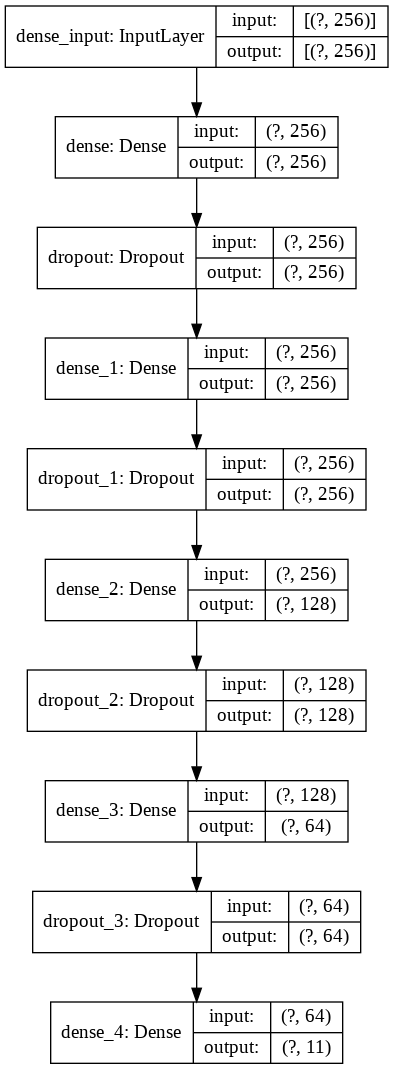

In [16]:
from tensorflow.keras.utils import plot_model

plot_model(classifier, show_shapes = True, to_file='model.png')

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
from tensorflow.keras.callbacks import ModelCheckpoint
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size
import time
t_0=time.time()

filepath = './DNN4layer_dropout.wts.h5'
history = classifier.fit(X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
      validation_data=(X_valid, y_valid),
    callbacks = [
        tensorflow.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

delta_t=time.time()-t_0
print(delta_t)
# we re-load the best weights once training is finished
classifier.load_weights(filepath)

Epoch 1/100
86/86 - 1s - loss: 2.3459 - accuracy: 0.1405 - val_loss: 2.2184 - val_accuracy: 0.1815
Epoch 2/100
86/86 - 0s - loss: 2.1774 - accuracy: 0.1900 - val_loss: 2.0601 - val_accuracy: 0.2413
Epoch 3/100
86/86 - 0s - loss: 1.9976 - accuracy: 0.2543 - val_loss: 1.8662 - val_accuracy: 0.3073
Epoch 4/100
86/86 - 0s - loss: 1.8527 - accuracy: 0.3028 - val_loss: 1.7677 - val_accuracy: 0.3355
Epoch 5/100
86/86 - 0s - loss: 1.7640 - accuracy: 0.3311 - val_loss: 1.7118 - val_accuracy: 0.3500
Epoch 6/100
86/86 - 0s - loss: 1.7029 - accuracy: 0.3507 - val_loss: 1.6721 - val_accuracy: 0.3650
Epoch 7/100
86/86 - 0s - loss: 1.6498 - accuracy: 0.3683 - val_loss: 1.6431 - val_accuracy: 0.3762
Epoch 8/100
86/86 - 0s - loss: 1.6115 - accuracy: 0.3819 - val_loss: 1.6169 - val_accuracy: 0.3830
Epoch 9/100
86/86 - 0s - loss: 1.5751 - accuracy: 0.3941 - val_loss: 1.5978 - val_accuracy: 0.3924
Epoch 10/100
86/86 - 0s - loss: 1.5473 - accuracy: 0.4048 - val_loss: 1.5807 - val_accuracy: 0.4004
Epoch 11/

In [18]:
# Show simple version of performance
#score = classifier.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
#print(score)
scscore = classifier.evaluate(X_test, y_test, batch_size=batch_size)
print(classifier.metrics_names)
print (scscore)

108/108 [==============================] - 0s 3ms/step - loss: 1.5442 - accuracy: 0.4104
['loss', 'accuracy']
[1.5441548824310303, 0.4104454517364502]


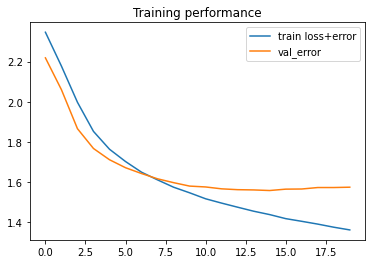

In [19]:
# Show loss curves 

# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

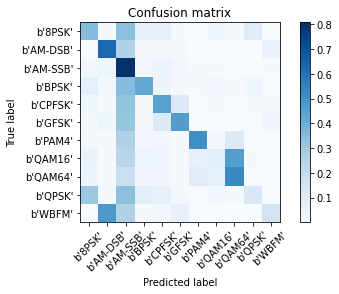

In [21]:
# Plot confusion matrix
test_Y_hat = classifier.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)): 
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)


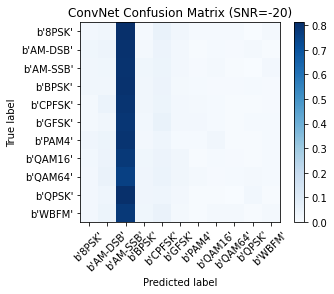

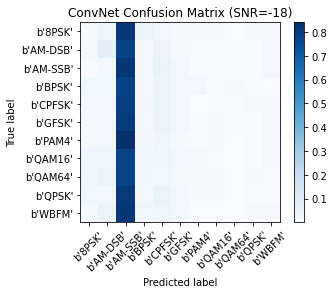

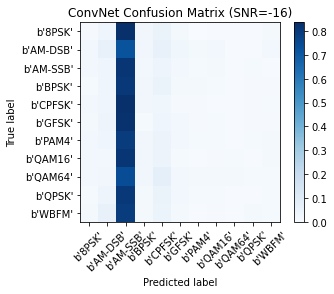

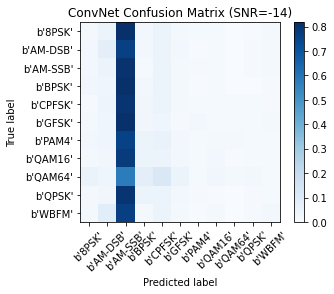

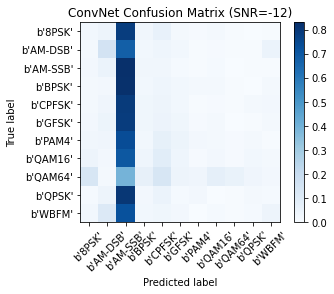

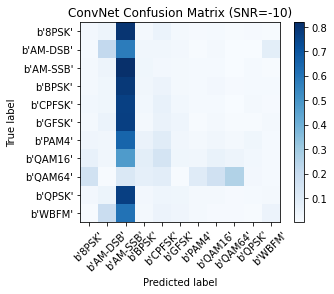

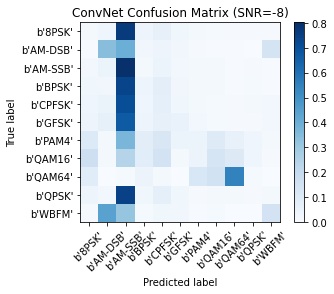

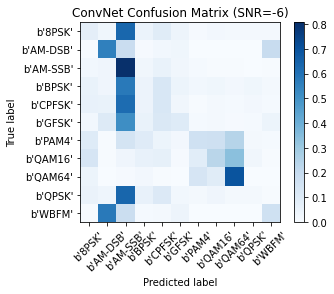

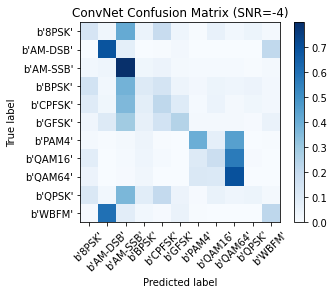

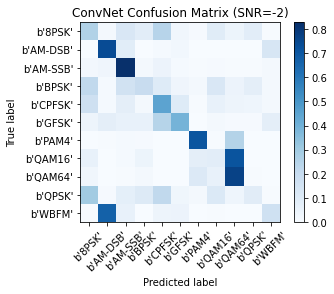

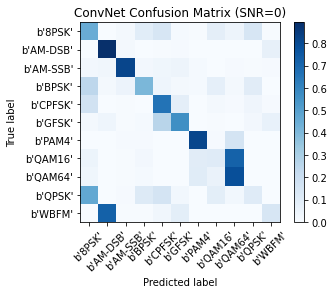

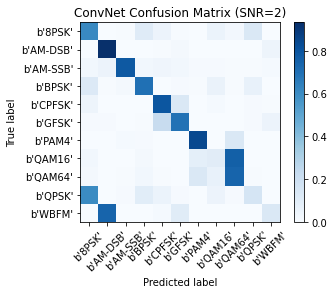

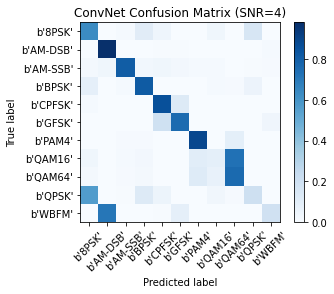

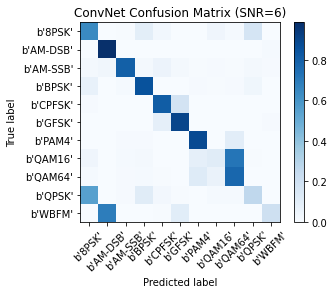

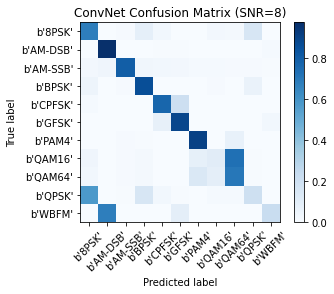

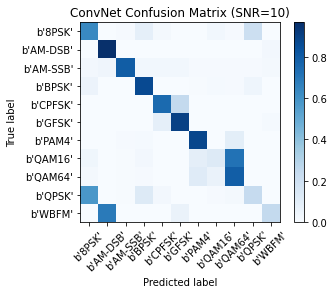

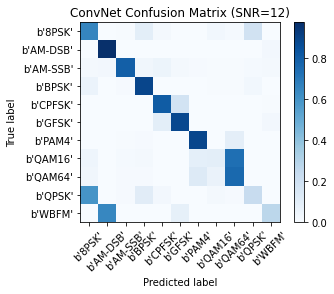

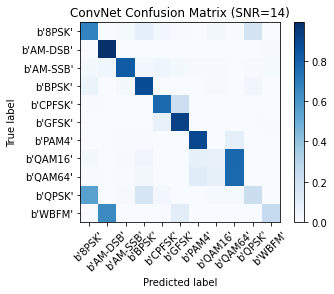

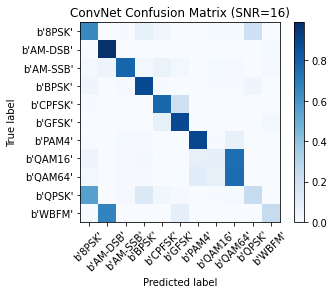

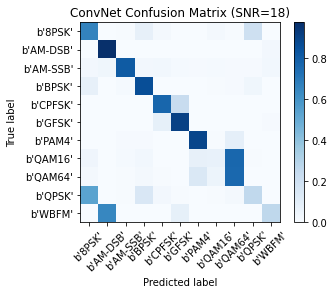

In [22]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    #print(snr)
    #print(np.array(list(test_SNRs)))
    #print(np.where(np.array(list(test_SNRs))==snr))
    
    mask = np.where(np.array(list(test_SNRs))==snr)
    #print("mask:{}".format(mask))
    test_X_i = X_test[mask]
    test_Y_i = y_test[mask] 
    
#     print(test_X_i.shape)
#     print(test_Y_i.shape)

    # estimate classes
    test_Y_i_hat = classifier.predict(test_X_i)
    #print(test_Y_i_hat)
    
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        # print( list(test_Y_i[i,:]))
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1 
    
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    plt.figure(figsize = (5,4))
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    plt.savefig("../content/ Confusion Matrix SNR_{}.jpg".format(snr))
    
    cor = np.sum(np.diag(conf))
    #print(test_X_i)
    ncor = np.sum(conf) - cor
    acc[snr] = 1.0*cor/(cor+ncor)
    
   # print("Overall Accuracy: ", acc[snr])

In [23]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []


snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])


#print(snr_label_array)
y_test_snr=snr_array[test_idx]



for snr in snr_label_array:
    test_X_i = X_test[np.where(y_test_snr==snr)]
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = classifier.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))

print("Random Guess Accuracy:",1/11)

Overall Accuracy:  0.09303160919540229 for SNR b'-20'
Overall Accuracy:  0.09764555575835006 for SNR b'-18'
Overall Accuracy:  0.09484313018391634 for SNR b'-16'
Overall Accuracy:  0.09290416971470374 for SNR b'-14'
Overall Accuracy:  0.11170688114387846 for SNR b'-12'
Overall Accuracy:  0.14622034210042303 for SNR b'-10'
Overall Accuracy:  0.1989644970414201 for SNR b'-8'
Overall Accuracy:  0.26786040562762653 for SNR b'-6'
Overall Accuracy:  0.33739691645751163 for SNR b'-4'
Overall Accuracy:  0.4264705882352941 for SNR b'-2'
Overall Accuracy:  0.5270121278941565 for SNR b'0'
Overall Accuracy:  0.5941582002902758 for SNR b'2'
Overall Accuracy:  0.6329368709972553 for SNR b'4'
Overall Accuracy:  0.6615299944964227 for SNR b'6'
Overall Accuracy:  0.6494066882416397 for SNR b'8'
Overall Accuracy:  0.6506495817761168 for SNR b'10'
Overall Accuracy:  0.6541052248316038 for SNR b'12'
Overall Accuracy:  0.6633303002729755 for SNR b'14'
Overall Accuracy:  0.6556061987237921 for SNR b'16'
Ove

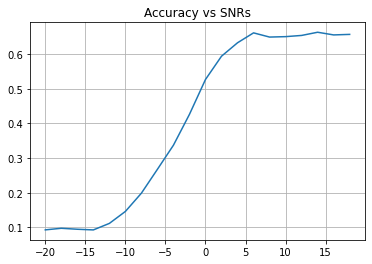

In [24]:
# Show loss curves 
plt.figure()
plt.title('Accuracy vs SNRs')
plt.plot(np.arange(-20,20,2), acc_array)
plt.grid()